In [1]:
# Script to calculate generality and  application data
# Generality: how diverse is the impact of a patent
# This is done by calculating the herfindal index of citing patents

# Feb 7th, 2020
# While the previous version is already up, I want to improve the script
# I want to make calculations with only one script
# Also, I want to compare different class systems
# this version took 10 minutes - i am moving the old version away

# Jan 16th, 2020
# Due to performance problems in the HPC, this script was divided in two, the script following this is generality_2
# generality > 1 is not an error, but a consequence of adopting WIPO
# it seems that the original calculation had only one class per patent
# WIPO provides multiple classes - so when you divide by the total number of citations, 
#  you do not have the proportion of classes cited anymore
# to correct this issue, I can calculate Generality and Originality based only on the first WIPO class

# Jan 13th, 2020
# Script is running but there are two major issues
# - there should not exist generality > 1 , so there is an error in calculation
# - too many NANs (about 400k), but I will tackle this issue in 'too_many_nans.ipynb'

# to tackle the first problem, I'll begin by creating a subset of the database
# to do that, I'll use USPTO classification system

In [2]:
import pandas as pd
import numpy as np
import re

import dask.dataframe as dd
from dask.delayed import delayed

import glob
import graphviz

file_list=glob.glob("data/citation/*")
classification = 'data/wipo.parquet.gz'
dst= 'data/generality.parquet.gz'

dfs = [delayed(pd.read_parquet)(f, columns=['patent_id']) for f in file_list]
class_df=pd.read_parquet(classification, columns=['wipo_sector_id'])

In [3]:
def join_class(df, class_df):
    df=delayed(df.join)(class_df, how='inner')
    df=delayed(pd.get_dummies)(df, columns=['wipo_sector_id'])
    return df

In [4]:
def total_citation(df):
    return total_citation, df

In [5]:
#its a measure of concentration
# as defined in Hall et al, 2001

def generality(df):
    total_citation=np.square(df.groupby(df.index).count().iloc[:,0])
    df=df.groupby(df.index).sum().fillna(0)
    df_squared=np.square(df) #element-wise squaring
    df_squared=df_squared.sum(axis='columns') #sum all columns, per row
    df=dd.concat([df_squared, total_citation], axis=1)
    generality=1-(df2['df_squared']/df2['total_citation'])    

In [7]:
for i,dfx in enumerate(dfs):
    dfx=join_class(dfx, class_df)
    if i==0:
        df=dfx
    else:
        df=delayed(dd.concat)([df,dfx])

In [8]:
# patent_id is the citing patent
# citation_id (the index) is the cited patent

In [9]:
generality=delayed(generality)(df)

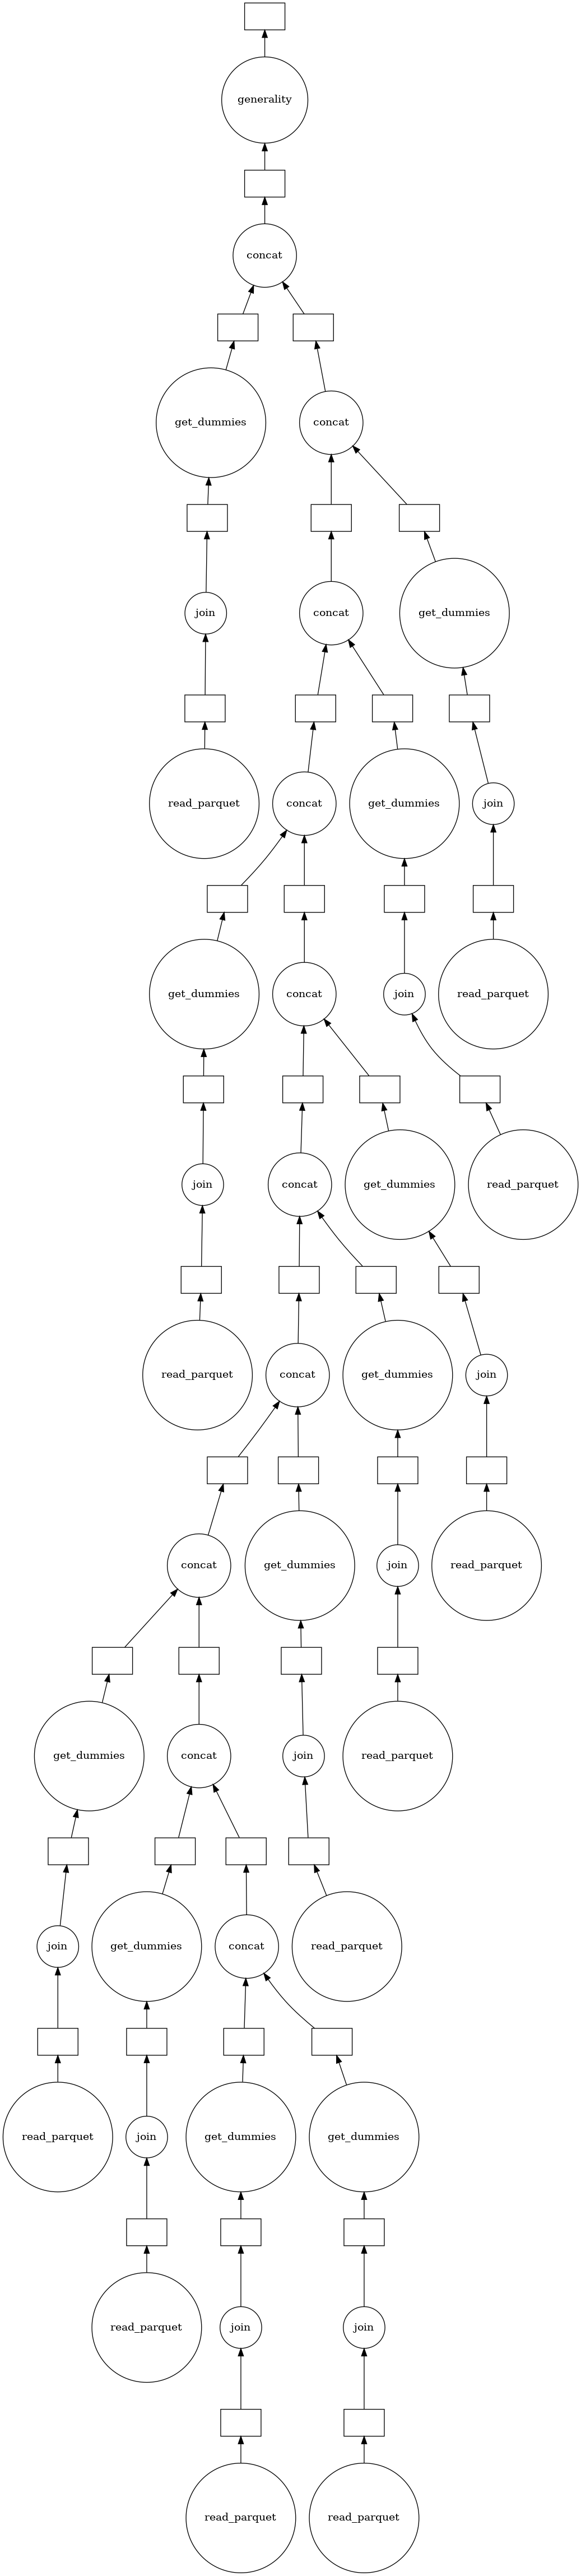

In [10]:
generality.visualize()

In [ ]:
%%time
generality.compute().to_parquet(dst, compression='gzip')